#### Preparación para correr el código

In [1]:
import cv2;
import numpy as np;
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from scipy import stats
from scipy.stats import skew
from IPython.display import display

import sys

print("Python version %s / OpenCV version %s " %(sys.version,cv2.__version__))

Python version 3.11.8 (main, Feb 12 2024, 14:50:05) [GCC 13.2.1 20230801] / OpenCV version 4.9.0 


# Guía 1 - Ejercicio 3
Utilice las herramientas aprendidas en esta unidad para implementar un sistema
que permita identificar una botella que no esta correctamente llena. Las imagenes que se proporcionaran son capturadas con una camara fija, en escala de grises y directamente de la linea de envasado. Para implementar el sistema debera bastarle una imagen de ejemplo \botella.tif" (que encontrara en el repositorio). Adicionalmente, se espera que el sistema pueda:
1. Identificar una botella no-llena en cualquier posicion de la imagen.
2. Indicar la posicion de la botella en la imagen (podria ser con un recuadro,
informando la posicion relativa entre botellas, la posicion absoluta en pixels,
etc).
3. Informar el porcentaje de llenado de la botella no-llena.

Resolucion:
- Se inicia tomando la fila que representa la mitad de la imagen y se la recorre reconociendo donde inicia y termina cada botella a partir del cambio de intensidad de gris entre un elemento actual y el anterior.
- Tomando una botella, se calcula el tamaño en altura quitando la parte negra que representa el fondo. Se supone que alrededor de un 80% de la botella contiene líquido si se encuentra llena.
- A partir de estos valores, se recorre la lista de botellas reconociendo si contiene zonas vacías por debajo del umbral anterior. De ser así, se agrega a la lista de botellas vacías y se calcula el porcentaje faltante haciendo una comparativa entre zonas con líquido y sin el mismo.
- Por último, todas las coordenadas obtenidas de la botellas permiten fácilmente marcar con un rectángulo aquellas que se encuentren no-llena.

Datos de imagen. Tipo: uint8, Alto: 196, Ancho: 285


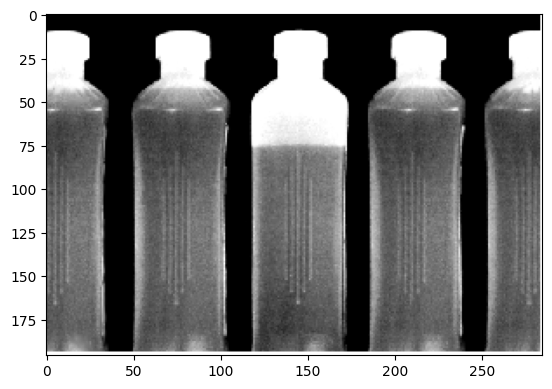

In [2]:
img_path = "images/botellas.tif"
# img_path = "images/botellas_larga.tif" #Imagen con mas cantidad de botellas

img_botella = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # gris
img_final = cv2.cvtColor(img_botella,cv2.COLOR_GRAY2RGB) # en color

H,W=img_botella.shape # altura y ancho de la imagen
imtype=img_botella.dtype # tipo de imagen

print("Datos de imagen. Tipo: %s, Alto: %d, Ancho: %d" %(imtype,H,W))

plt.imshow(img_botella,cmap='gray')
plt.show()

Lista de botellas (Nro, Xinicial, Xfinal):  [[1, 0, 33], [2, 49, 103], [3, 117, 172], [4, 185, 238], [5, 252, 283]]
Nro de botella no-llena y porcentaje de liquido:  [[3, 81.76]]


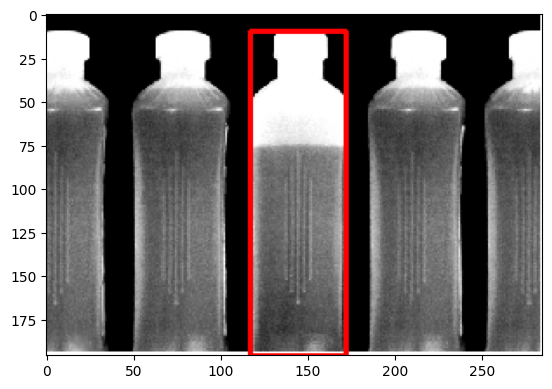

In [3]:
#Contar botellas con x_inicio y x_final
x_inicial = 0 #Por las dudas ya se incluye el primer pixel si este contiene una botella
x_final = -1
contador = 0
lista_botellas = [] #[nro_botella,x_inicial,x_final]
lista_vacias = [] #[nro_botella,porcentaje_llena]
punto_medio = H // 2

#Reconocer y contar botellas
for i in range(0,W):
  #Valor donde empieza una botella
  if (img_botella[punto_medio,i] == 0 and img_botella[punto_medio,i+1] != 0):
    x_inicial = i

  #Valor donde termina una botella (teniendo en cuenta si termina sin una botella completa)
  if ((img_botella[punto_medio,i-1] != 0 and img_botella[punto_medio,i] == 0) or \
      (i == W-1 and img_botella[punto_medio,i-1] != 0)):
    x_final = i-1
    contador = contador+1
    lista_botellas.append([contador,x_inicial,x_final])

print("Lista de botellas (Nro, Xinicial, Xfinal): ",lista_botellas)

#Calcular altura de la botella
#Punto medio de una botella (se toma la segunda para asegurarse que sea completa)
medio_botella = lista_botellas[1][1] + ((lista_botellas[1][2] - lista_botellas[1][1]) // 2)
tamanio = np.count_nonzero(img_botella[:,medio_botella]) #Tamaño de la botella, descartando lo negro
#Suponemos que al 80% de la altura, la botella se encuentra llena
llena = (80*tamanio) // 100

#Recorremos todas las botellas para encontrar las vacias
for i in range(0,len(lista_botellas)-1):
  medio_botella = lista_botellas[i][1] + ((lista_botellas[i][2] - lista_botellas[i][1]) // 2) #Punto medio de una botella
  total_vacio = np.count_nonzero(img_botella[H-llena:H-2,medio_botella] > 200) # >200 valores correspondientes a zona sin liquido
  if total_vacio != 0:
    porcentaje_lleno = 100-round((total_vacio * 100) / (llena),2)
    lista_vacias.append([i+1,porcentaje_lleno])
    cv2.rectangle(img_final, (lista_botellas[i][1], H-tamanio), (lista_botellas[i][2], H), (255,0,0), 2)

print("Nro de botella no-llena y porcentaje de liquido: ",lista_vacias)

plt.figure()
plt.imshow(img_final)
plt.show()

# Guía 2 - Ejercicio 4.2
Al final del proceso de manufacturación de placas madre de marca ASUS, modelo A7V600, se obtienen dos clases de producto final: A7V600-x y A7V600-SE. Implemente un algoritmo que, a partir de una imagen, determine que tipo de placa es. Haga uso de las técnicas de realce aprendidas y utilice las imágenes *a7v600-x.gif* y *a7v600-se.gif*. Adapte el método de forma que contemple reconocimiento de imágenes que han sido afectadas por un ruido aleatorio impulsivo (*a7v600-x(RImpulsivo).gif* y *a7v600-SE(RImpulsivo).gif*).

Resolucion:
- Se comienza realizando la operacion de resta entre la imagen de la placa 1 y la placa 2, obteniendo asi las diferencias visibles entre una y otra.
- A partir del resultado, se seleccionan las zonas mas representativas de diferencia con las que realizar el estudio.
- Se le aplica una transformacion de potencia (o corrección gamma) a las imagenes con un valor de gamma=2 (mayor a 1 para resaltar las zonas oscuras, que terminan quedando mas oscuras).
- Se recorre cada una de las zonas de las respectivas placas, calculando el promedio de valores con una intensidad mayor a un valor definido.
- El promedio de los valores obtenidos por zona de cada placa, será el valor que permita identificar a que tipo pertenece.
- En cuanto a las imagenes con ruido, el algoritmo se adapta con satisfaccion y se puede observar que los promedios de ambos tipos de placas mantienen un intervalo de diferencia considerable.

In [4]:
## Funciones utilizadas

# Aplicar transformacion de potencia (no lineal) a una imagen
def pow_transformation(srcImg,c=1,gamma=1,lookUpTable=None):
    outImg = srcImg.copy()
    if lookUpTable is None:
        lookUpTable = np.empty((1,256), np.uint8)
        for i in range(256):
            lookUpTable[0,i] = np.clip(255 * pow(i/255,gamma),0,255)

    outImg = cv2.LUT(srcImg,lookUpTable)
    return outImg

# Resta entre dos imagenes
def diff_images(img1,img2):
  diff_image = img1.astype(np.float64)-img2.astype(np.float64)
  diff_image =  0.5 * (diff_image + 255*np.ones_like(diff_images))

  return diff_image.astype(np.uint8)

# Abrir un archivo .gif y convertirlo en un numpy.ndarray
def gif2array(path):
  gif = cv2.VideoCapture(path)
  frames_array = []
  while (gif.isOpened()):
    ret, frame = gif.read()
    if not ret:
      break
    frames_array.append(frame)

  return frames_array

# Generar una mascara binaria a partir de una imagen que hace nulos
# todos los valores de intensidad menores al valor definido como parametro
def mask_below(img,value):
  mask = np.ones_like(img)

  for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      for c in range(img.shape[2]):
        if img[y,x,c] < value:
          mask[y,x] = 0

  return mask.astype(np.float32)

# Funcion para promediar las zonas de interes y detectar valores que diferencian a cada placa
def aplicar_mascara(path,zonas,mask_max=20,z=None):
  img = gif2array(path)
  img = np.array(img[0])

  img_zona = img[zonas[0][0]:zonas[0][1],zonas[1][0]:zonas[1][1],:].copy()
  img_pow = pow_transformation(img_zona,gamma=2)
  img_mascara = mask_below(img_pow,mask_max)
 
  if z is not None:
    plt.subplot(2,5,z)
    plt.imshow(img_pow)
    plt.subplot(2,5,z+5)
    plt.imshow(img_mascara)

  return img_mascara


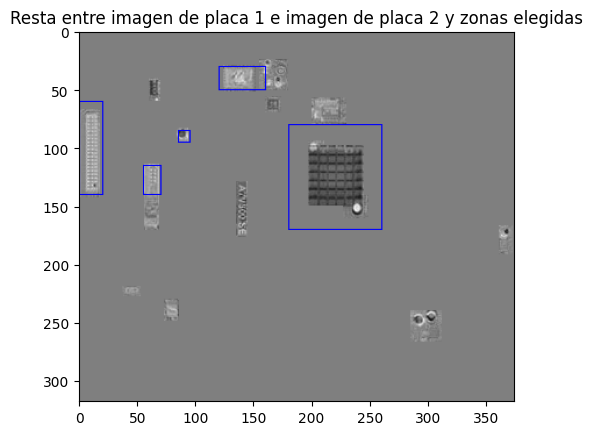

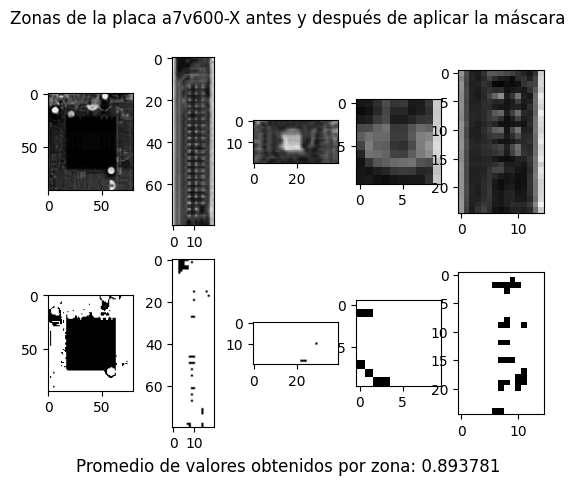

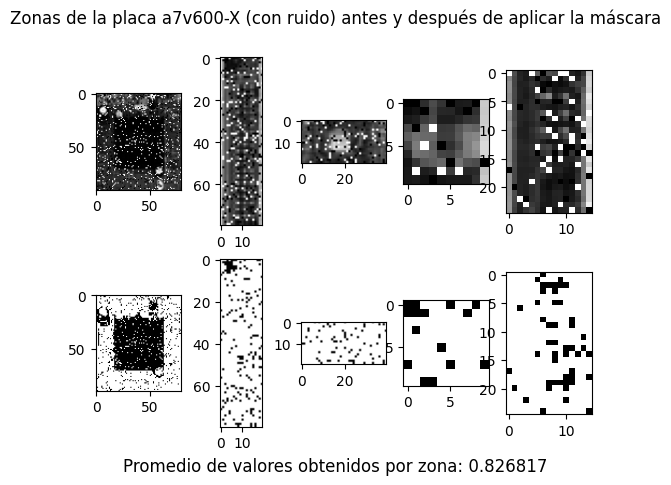

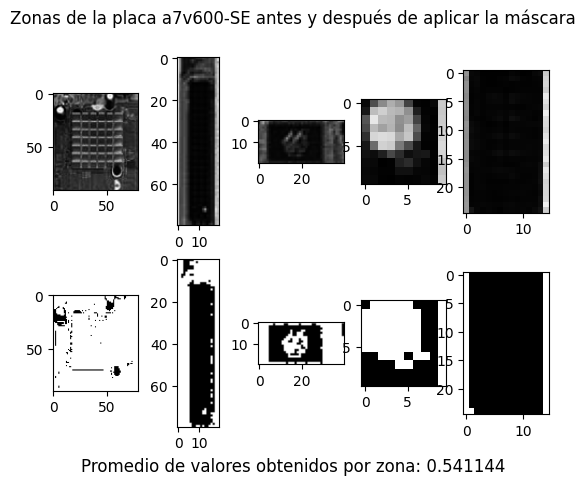

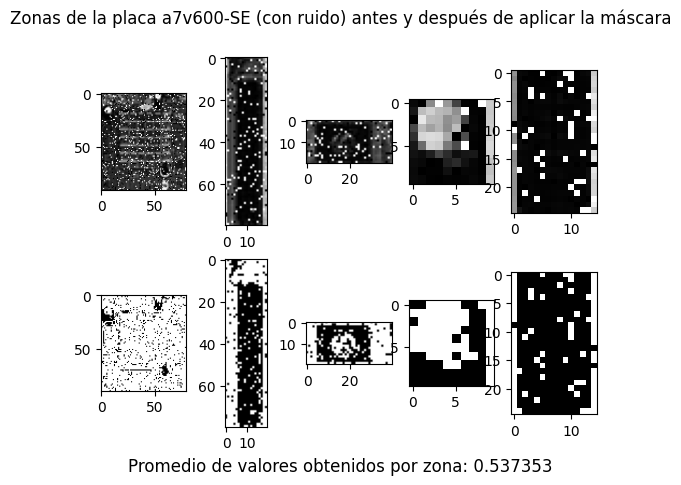

Promedios: [0.89378055 0.82681667 0.54114444 0.53735279]
Imagenes a clasificar

Imagen 1: a7v600-X
Resultado clasificar la primera imagen:  Placa A7V600-X - Valor promedio obtenido: 0.893781

Imagen 2: a7v600-X (con ruido)
Resultado clasificar la segunda imagen:  Placa A7V600-X - Valor promedio obtenido: 0.826817

Imagen 3: a7v600-SE
Resultado clasificar la tercera imagen:  Placa A7V600-SE - Valor promedio obtenido: 0.541144

Imagen 4: a7v600-SE (con ruido)
Resultado clasificar la cuarta imagen:  Placa A7V600-SE - Valor promedio obtenido: 0.537353


In [5]:
path_placas = [
  "images/a7v600-X.gif",
  "images/a7v600-X(RImpulsivo).gif",
  "images/a7v600-SE.gif",
  "images/a7v600-SE(RImpulsivo).gif"]
titles = [
  "a7v600-X",
  "a7v600-X (con ruido)",
  "a7v600-SE",
  "a7v600-SE (con ruido)"]

img1 = gif2array(path_placas[0])
img1 = np.array(img1[0])

img2 = gif2array(path_placas[2])
img2 = np.array(img2[0])

#Resta entre placas de diferente tipo
diff = diff_images(img1,img2)

# Zonas de interes en las placas madres (definidas despues de visualizar la resta entre
# las imagenes de las placas)
zonas = [
  [(80,170),(180,260)],
  [(60,140),(0,20)],
  [(30,50),(120,160)],
  [(85,95),(85,95)],
  [(115,140),(55,70)]
]

diff_zonas  = diff.copy()
for zona in zonas:
  cv2.rectangle(diff_zonas,(zona[1][0],zona[0][0]),(zona[1][1],zona[0][1]),(0,0,255),1)


plt.figure()
plt.title("Resta entre imagen de placa 1 e imagen de placa 2 y zonas elegidas")
plt.imshow(diff_zonas,cmap='gray')
plt.show()

#Promedio de valor de intensidades en zonas de interes
means = np.zeros(len(path_placas))
figs=[]
for i in range(len(path_placas)):
  mean_placa = 0
  plt.figure()
  fig = plt.gcf()
  fig.suptitle("Zonas de la placa %s antes y después de aplicar la máscara"%titles[i])
  figs.append(fig)
  for z in range(len(zonas)):
    img_placa  = aplicar_mascara(path_placas[i],zonas[z],20,z+1)
    mean_placa += np.mean(img_placa)
  mean_placa /= len(zonas)
  fig.supxlabel("Promedio de valores obtenidos por zona: %f"%mean_placa)
  means[i] = mean_placa
  plt.show()

print("Promedios: %s"%means)

# Funcion que clasifica las placas a partir de los promedios
# Se toma como referencia el valor promedio obtenido, si el valor es mayor a 0.7
# entonces es del tipo A7V600-X, sino es de tipo A7V600-SE
def clasificar_placa(path,zonas):
  mean = 0
  for zona in zonas:
    img_placa  = aplicar_mascara(path,zona,20)
    mean += np.mean(img_placa)
  mean /= len(zonas)
  if (mean >= 0.7):
    return "Placa A7V600-X - Valor promedio obtenido: %f"%(mean)
  else:
    return "Placa A7V600-SE - Valor promedio obtenido: %f"%(mean)

#Pruebas

print("Imagenes a clasificar")
print()

print("Imagen 1: %s"%titles[0])
print("Resultado clasificar la primera imagen: ",clasificar_placa(path_placas[0],zonas))
print()

print("Imagen 2: %s"%titles[1])
print("Resultado clasificar la segunda imagen: ",clasificar_placa(path_placas[1],zonas))
print()

print("Imagen 3: %s"%titles[2])
print("Resultado clasificar la tercera imagen: ",clasificar_placa(path_placas[2],zonas))
print()

print("Imagen 4: %s"%titles[3])
print("Resultado clasificar la cuarta imagen: ",clasificar_placa(path_placas[3],zonas))

# Guía 2 - Ejercicio 4.3
En una fábrica de medicamentos se desea implementar un sistema para la inspeccíon visual automática de blisters en la línea de empaquetado. La adquisición de la imagen se realiza en escala de grises mediante una cámara CCD fija y bajo condiciones controladas de iluminación, escala y enfoque. El objetivo consiste en determinar en cada instante si el blister que está siendo analizado se encuentra incompleto, en cuyo caso la región correspondiente a la píldora faltante presenta una intensidad similar al fondo. Escriba una función que reciba como parámetro la imágen del blister a analizar y devuelva un mensaje indicando si el mismo contiene la totalidad o no de las píldoras. En caso de estar incompleto, indique la posición $(x,y)$ de las píldoras faltantes. Verifique el funcionamiento con las imágenes *blister_completo.jpg* y *blister_incompleto.jpg*.

Resolucion:
- Bajo la suposicion de que cualquier imagen de un blister no presente diferencias de enfoque, ruido, orientacion u otras modificaciones, se decide realizar la operacion resta entre un blister lleno y otro a analizar.
- El resultado de esta operacion sera una imagen al que se le podra calcular el promedio de intensidad, el cual presentara un valor de 127 al ser toda la imagen gris (blister completo) o de un valor diferente a este al contener una o mas pildoras (blister incompleto).
- Como adicion, la imagen resultante permite facilmente realizar una busqueda sobre las filas de pildoras encontrando aquellas faltantes, pudiendo asi enumerar e informar las coordenadas de las mismas.

Blister Completo
Blister Incompleto
Pildora faltante Nro 1, Posicion X: 154, Posicion Y: 100


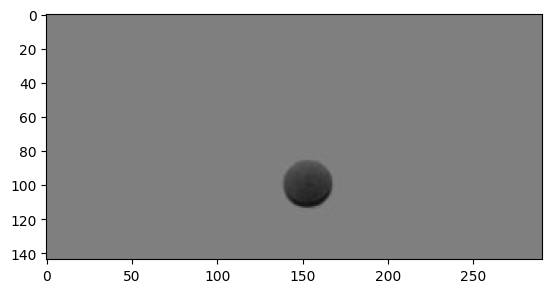

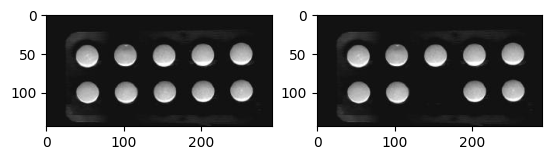

In [6]:
path_blister_completo = "images/blister_completo.jpg"
path_blister_incompleto = "images/blister_incompleto.jpg"

blister_completo = cv2.imread(path_blister_completo,cv2.IMREAD_GRAYSCALE)
blister_incompleto = cv2.imread(path_blister_incompleto,cv2.IMREAD_GRAYSCALE)

diff_blister = diff_images(blister_incompleto,blister_completo[:,0:blister_completo.shape[1]-1])

#Encontrar pildoras faltantes analizando las diferencias entre fondo(gris == 127) y pildora (gris != 127)
def find_missing(img):
  lista_faltante = []
  contador = 0
  for i in range(1,img.shape[1]-1):
    if (img[50,i] != 127 and img[50,i-1] == 127):
      x_inicial_1 = i
    if (img[50,i+1] == 127 and img[50,i] != 127):
      x_final_1 = i
      contador = contador + 1
      lista_faltante.append([contador,x_inicial_1+(x_final_1-x_inicial_1)/2,50])

    if (img[100,i] != 127 and img[100,i-1] == 127):
      x_inicial_2 = i
    if (img[100,i+1] == 127 and img[100,i] != 127):
      x_final_2 = i
      contador = contador + 1
      lista_faltante.append([contador,x_inicial_2+(x_final_2-x_inicial_2)/2,100])
  #Notificar pildoras faltantes
  for j in range(0,contador):
    print("Pildora faltante Nro %d, Posicion X: %d, Posicion Y: %d" %(lista_faltante[j][0],lista_faltante[j][1],lista_faltante[j][2]))


# Si el promedio de los valores de la imagen es distinto de 128 (gris obtenido de restar dos imagenes iguales)
# entonces hay una diferencia en el contenido de los blister
def is_full(img):
    full_blister = cv2.imread(path_blister_completo,cv2.IMREAD_GRAYSCALE)
    diff_blister = diff_images(img,full_blister[:,0:blister_completo.shape[1]-1])
    if (np.mean(diff_blister) != 127.0):
        print("Blister Incompleto")
        find_missing(diff_blister)
    else:
        print("Blister Completo")


# Pruebas con la imagen  del blister completo e incompleto
is_full(blister_completo[:,0:blister_completo.shape[1]-1])
is_full(blister_incompleto)

plt.figure()
plt.imshow(diff_blister,cmap='gray',vmin=0,vmax=255)
plt.show()

fig,ax = plt.subplots(1,2)
ax[0].imshow(blister_completo,cmap='gray')
ax[1].imshow(blister_incompleto,cmap='gray')
plt.show()

# Guía 2.2 - Ejercicio 2
Los archivos *histo1.tif*, *histo2.tif*, *histo3.tif*, *histo4.tif* e *histo5.tif* contienen histogramas de imagenes con diferentes caracteristicas. Se pide:
- Analizando solamente los archivos de histograma y realice una descripcion de la imagen a la que corresponden (¿es clara u oscura?, ¿tiene buen contraste?, ¿el histograma me explica algo respecto de la ubicacion de los grises?, etc.).
- Anote la correspondencia histograma-imagen con los archivos *imagenA.tif* a *imagenE.tif*, basandose en su analisis previo.
- Cargue las imagenes originales y muestre los histogramas. Comparelos con sus respuestas del punto anterior.
- Obtenga y analice la utilidad de las siguientes propiedades estadisticas
de los histogramas: media, varianza, asimetria, energia y entropia.

Resolucion:
##### Histograma 1:
- Corresponde a una imagen con muchos pixeles oscuros (con valor entre 0 y 30) pero que tambien tiene muchos pixeles de intensidades mas claras en su distribución.
- Tiene un buen contraste porque hay los valores de intensidad estan dispersos a lo largo del histograma.
- Se corresponde a la Imagen C.
##### Histograma 2:
- Corresponde a una imagen con una gran cantidad de grises, y que no contiene valores de intensidad altos, por lo que no sera una imagen clara.
- Tiene un contraste medio-bajo, porque los valores de intensidad no varian mucho con respecto de la media.
- Se corresponde a la Imagen A
##### Histograma 3:
- Corresponde a una imagen oscura, ya que solo tiene valores de intensidad bajos y no presenta ninguno de intensidad mayor a 60.
- Tiene un contraste bajo, porque los valores de intensidad se concentran alrededor de la media.
- Se corresponde a la Imagen E
##### Histograma 4:
- Corresponde a una imagen clara, en la que no habra regiones oscuras ya que solo contiene una gran cantidad de valores de intensidad altos.
- Tiene un contraste bajo, los valores de intensidad no se encuentran muy lejos de la media.
- Se corresponde a la Imagen B
##### Histograma 5:
- Corresponde a una imagen clara, en la que podran verse tanto valores de intensidad altos como medios.
- Tiene un buen contraste, en el que se podran distinguir tanto regiones de alta intensidad como de intensidad media-baja.
- Se corresponde a la Imagen D

En cuanto a las propiedades estadisticas de un histograma, se pueden reconocer las siguientes utilidades de los mismos:
- Media: representa un valor promedio de las intensidades o niveles de gris de una imagen, lo cual corresponde a una medida cuantitativa del brillo promedio de la imagen. Se puede utilizar para la segmentacion de imagenes (ayudando a encontrar las ROI a partir de los umbrales), ecualizacion del histograma (observando si existen acumulaciones de intensidades bajas o altas) y ajuste de contraste.
- Varianza: representa la dispersion o variabilidad de los niveles de intensidad de la imagen alrededor de la media. En cuanto a su aplicacion, se la utiliza para analizar texturas (varianza alta = texturas rugosas y varianza baja = texturas suaves), detectar bordes (cambios bruscos de intensidad), filtrado de imagenes (suavizado y realce) y segmentacion de objetos.
- Asimetria: es una medida que representa si la distribucion de intensidades se encuentra sesgada hacia la izquierda o derecha en relacion con la media del histograma. Su utilidad se encuentra en el analisis de iluminacion (sesgo izquierdo = imagen oscura y sesgo derecho = imagen brillante), correccion de exposicion (sesgo izquierdo = imagen subespuesta  y sesgo derecho = imagen sobreexpuesta), deteccion de anomalias y segmentacion de objetos.
- Energia: representa la concentracion y distribucion de energia de los niveles de intensidad en la imagen. Su utilidad permite analisis de contraste (alta energia = alto contraste y baja energia = contraste bajo), seleccion de caracteristicas, segmentacion y filtrado de imagenes.
- Entropia: medida que representa la cantidad de informacion o incertidumbre en la distribucion de los niveles de intensidad de la imagen. Su utilidad se encuentra en el analisis de texturas, segmentacion de objetos, deteccion de cambios y compresion de imagenes (por ejemplo, a mayor entropia hay mayor informacion por lo que se puede optar por una menor compresion para mantener la calidad visual).


Media: 234.375000
Varianza: 211493.398438
Asimetría: 5.472323
Energía: 68204806.240014
Entropía: 4.671318


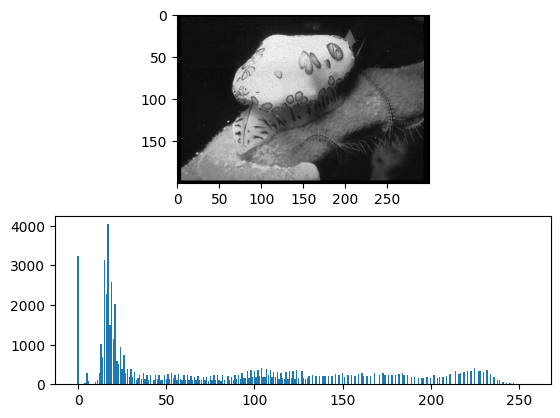


Media: 234.375000
Varianza: 131734.148438
Asimetría: 2.296401
Energía: 47786443.348961
Entropía: 4.569349


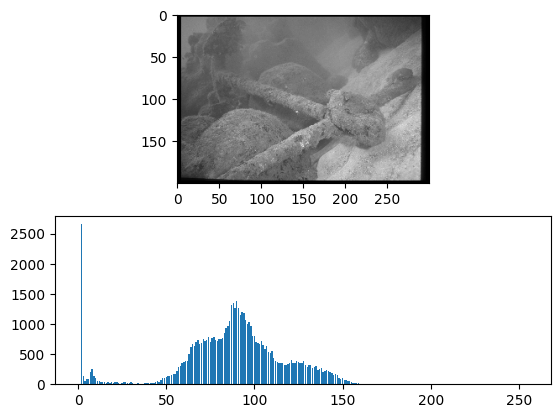


Media: 234.375000
Varianza: 392815.781250
Asimetría: 3.305872
Energía: 114623329.028782
Entropía: 3.606547


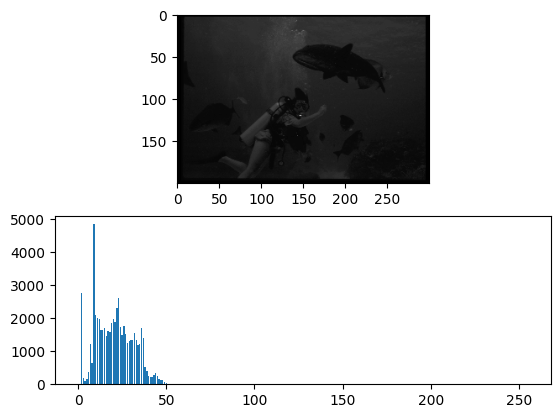


Media: 417.187500
Varianza: 726804.785156
Asimetría: 2.292346
Energía: 230617651.006211
Entropía: 4.062964


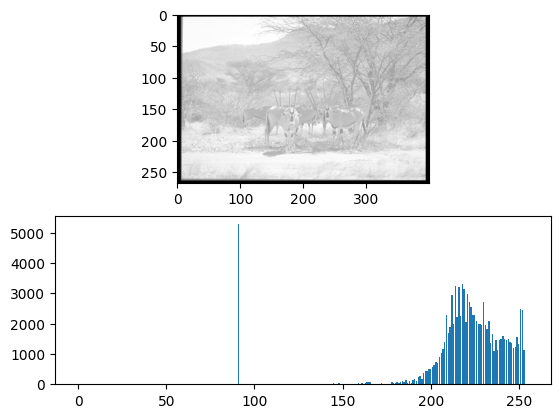


Media: 225.835938
Varianza: 23729.613708
Asimetría: -0.402981
Energía: 19131260.911194
Entropía: 5.206070


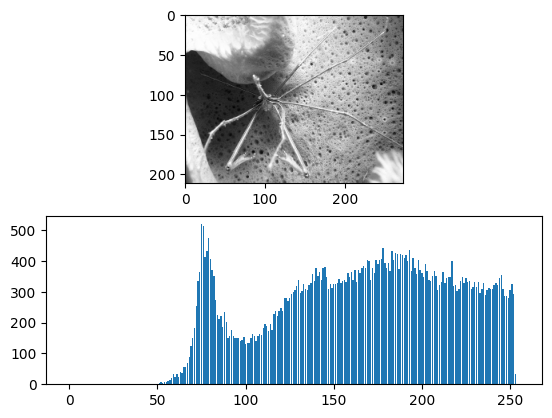

In [7]:
def show_imagen_histo(path):
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    mean,stdev = cv2.meanStdDev(hist)
    print()
    print("Media: %f"%(mean[0,0]))
    print("Varianza: %f"%(stdev[0,0]**2))
    print("Asimetría: %f"%(skew(hist[:,0])))
    print("Energía: %f"%np.linalg.norm(hist[:,0])**2)
    print("Entropía: %f"%stats.entropy(hist[:,0]))
    fig,ax = plt.subplots(2,1)
    ax[0].imshow(img,cmap='gray')
    ax[1].bar(range(256),np.squeeze(hist))
    plt.show()

path_list = [
    "images/imagenC.tif",
    "images/imagenA.tif",
    "images/imagenE.tif",
    "images/imagenB.tif",
    "images/imagenD.tif",
]
for path in path_list:
    show_imagen_histo(path)

# Guía 3 - Ejercicio 4.2
Aplique un filtro pasa-bajos de su eleccion y el filtro bilateral a las siguientes imagenes: *mariposa02.png*, *flores02.jpg* y *lapices02.jpg* (en escala de grises). Compare los resultados y explique sus apreciaciones.
- Utilice la funcion implementada en la guia anterior para visualizar perfiles de grises, eligiendo la misma fila o columna para la imagen original y las que
han sido filtradas. Compare los resultados visualizandolos simultaneamente.
- [Opcional] Implemente una funcion que le permita extraer perfiles de grises de las 3 imagenes, de cualquier longitud y en cualquier direccion (a partir de clicks del mouse o mediante el ingreso de coordenadas) y que realice el ploteo de los perfiles superpuestos en diferentes colores.

Resolucion:
- En primer lugar se definen las funciones a utilizar. En estas tendremos una para procesar la imagen (donde se aplican los filtros) y otro conjunto para trabajar los perfiles de grises elegidos para cada imagen (obtencion y ploteo).
- Una vez cargadas las imagenes, se les aplica un filtro bilateral y un filtro pasa-bajos (con un kernel de tamaño 9), y se estudian sus resultados.
- A partir de las graficas correspondientes a los perfiles de grises, se puede observar que el suavizado se encarga de modificar las frecuencias altas, promediando sus valores y disminuyendo los detalles de la imagen como los bordes; mientras que las frecuencias bajas se mantienen. Por otro lado, el filtro bilateral puede ser el mas indicado ya que respeta en gran medida las altas frecuencias, con lo cual se puede mantener una buena definicion en estas zonas, sumando ademas un resalte del objeto de interes contra el fondo o zonas de baja frecuencia de la imagen.

In [8]:
%matplotlib inline
path_imagenes = [
  "images/mariposa02.png",
  "images/flores02.jpg",
  "images/lapices02.jpg"
]

def process_image(path, kernel_size=5, bilateral_param=150,show=True):
  img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

  kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
  kernel /= (kernel_size**2)

  img_suavizado = cv2.filter2D(img,-1, kernel)
  img_bilateral = cv2.bilateralFilter(img,9,bilateral_param,bilateral_param)

  if show:
    fig,ax= plt.subplots(1,3)
    fig.set_size_inches(18.5, 10.5)
    ax[0].imshow(img,cmap='gray')
    ax[1].imshow(img_suavizado,cmap='gray')
    ax[2].imshow(img_bilateral,cmap='gray')

    ax[0].set_title("Imagen original")
    ax[1].set_title("Filtro pasa-bajos")
    ax[2].set_title("Filtro bilateral")
    plt.plot()

  return np.array([img_suavizado,img_bilateral])

def perfil_grises(img,i,dim=0):
    if dim == 0:
        return img[i,:]
    return img[:,i]

def plot_perfil_grises(perfiles):
    fig,ax= plt.subplots(1,3)
    fig.set_size_inches(18.5, 10.5)
    ax[0].plot(perfiles[0])
    ax[1].plot(perfiles[1])
    ax[2].plot(perfiles[2])
    plt.plot()

def plot_perfil_grises_superpuestos(perfiles):
    fig,ax= plt.subplots()
    ax.set_title("Perfiles de grises superpuestos")
    fig.set_size_inches(18.5, 10.5)
    ax.plot(perfiles[0])
    ax.plot(perfiles[1])
    ax.plot(perfiles[2])
    ax.legend(["Original","Filtro Pasa-Bajos", "Filtro Bilateral"])
    plt.plot()

def plot_perfil_sin_original(perfiles):
    fig,ax= plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.plot(perfiles[0])
    ax.plot(perfiles[1])
    ax.legend(["Filtro Pasa-Bajos", "Filtro Bilateral"])
    plt.plot()

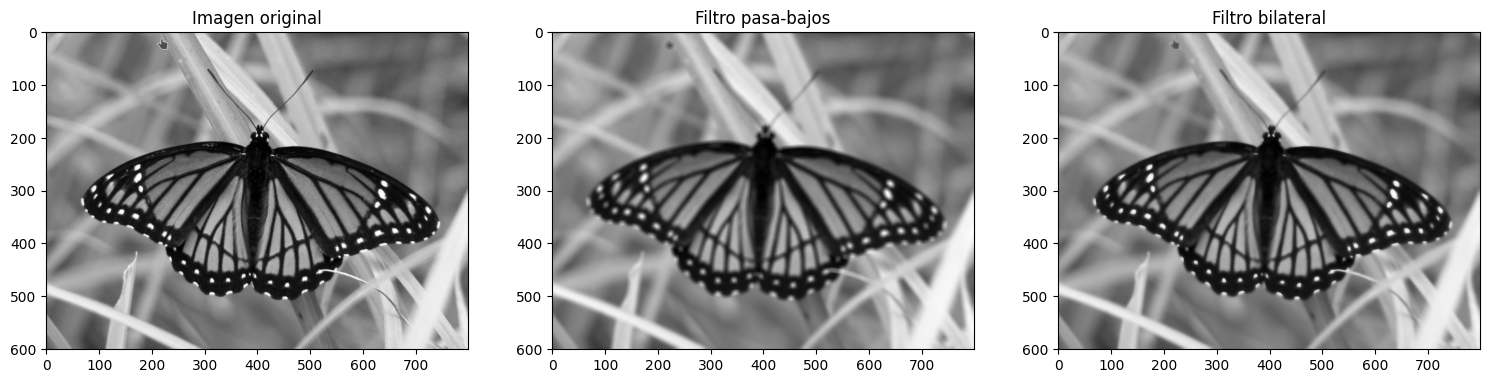

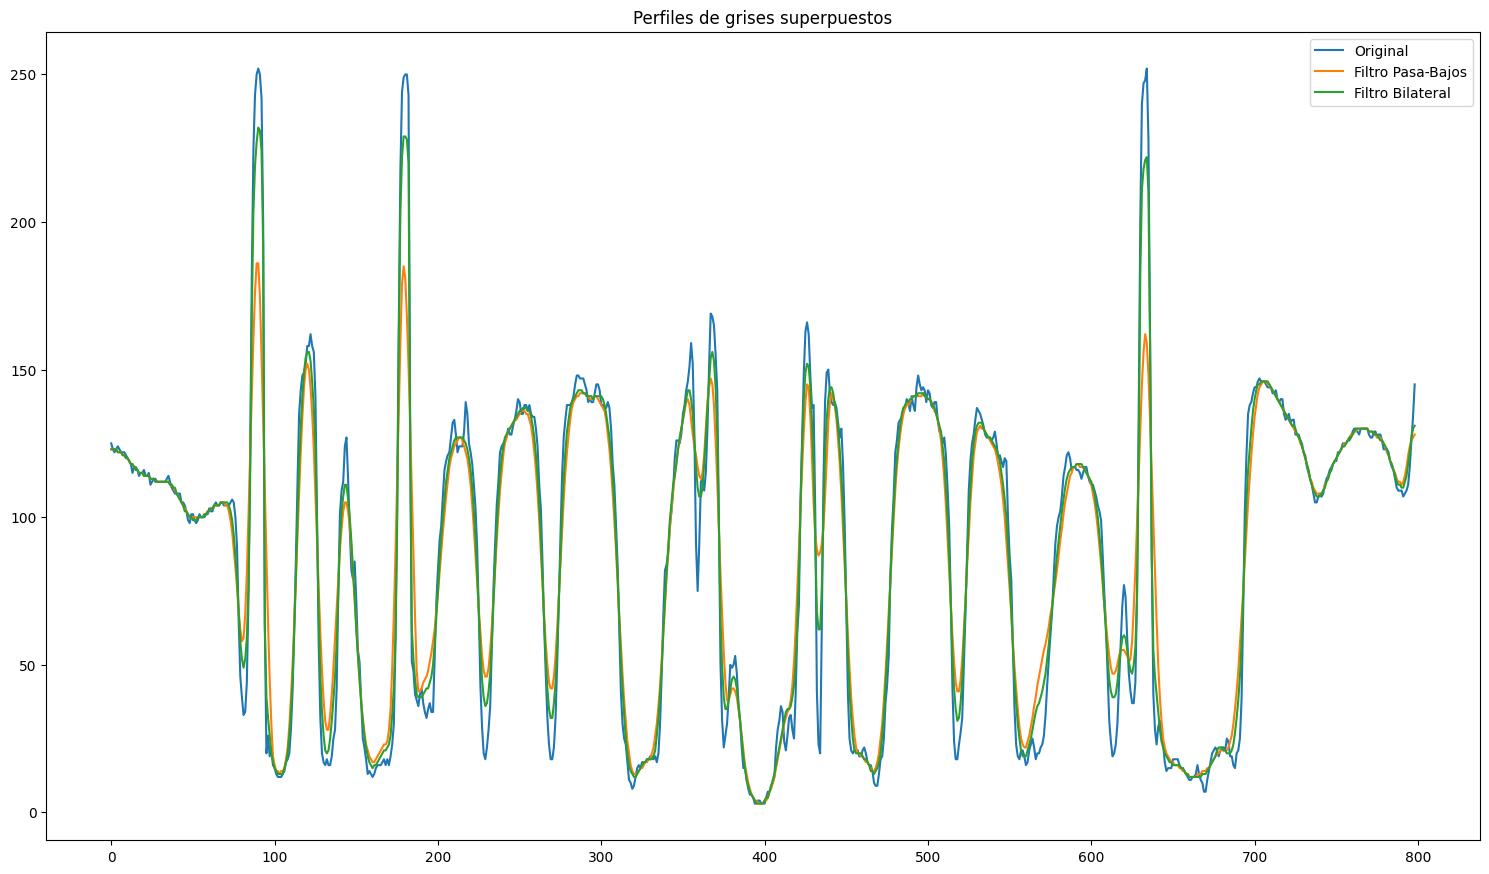

In [9]:
#Mariposa
mariposa= cv2.imread(path_imagenes[0],cv2.IMREAD_GRAYSCALE)
mariposa_procesada = process_image(path_imagenes[0],kernel_size=9,bilateral_param=100)
fix_line_mariposa = 300

perfil_mariposa = perfil_grises(mariposa,fix_line_mariposa,0)
perfil_mariposa_suav = perfil_grises(mariposa_procesada[0],fix_line_mariposa,0)
perfil_mariposa_bil = perfil_grises(mariposa_procesada[1],fix_line_mariposa,0)
perfiles_mariposa = [perfil_mariposa, perfil_mariposa_suav, perfil_mariposa_bil]

# plot_perfil_grises(perfiles_mariposa)
plot_perfil_grises_superpuestos(perfiles_mariposa)

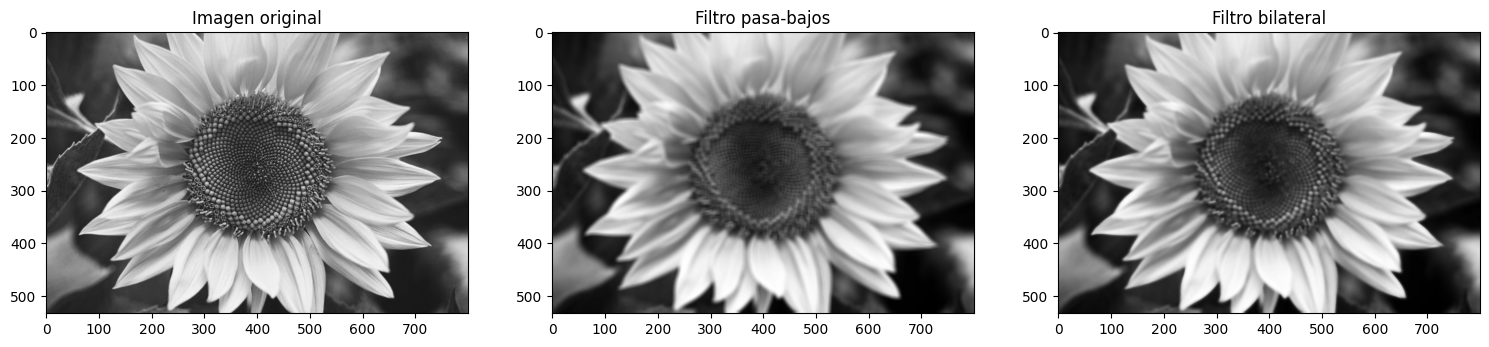

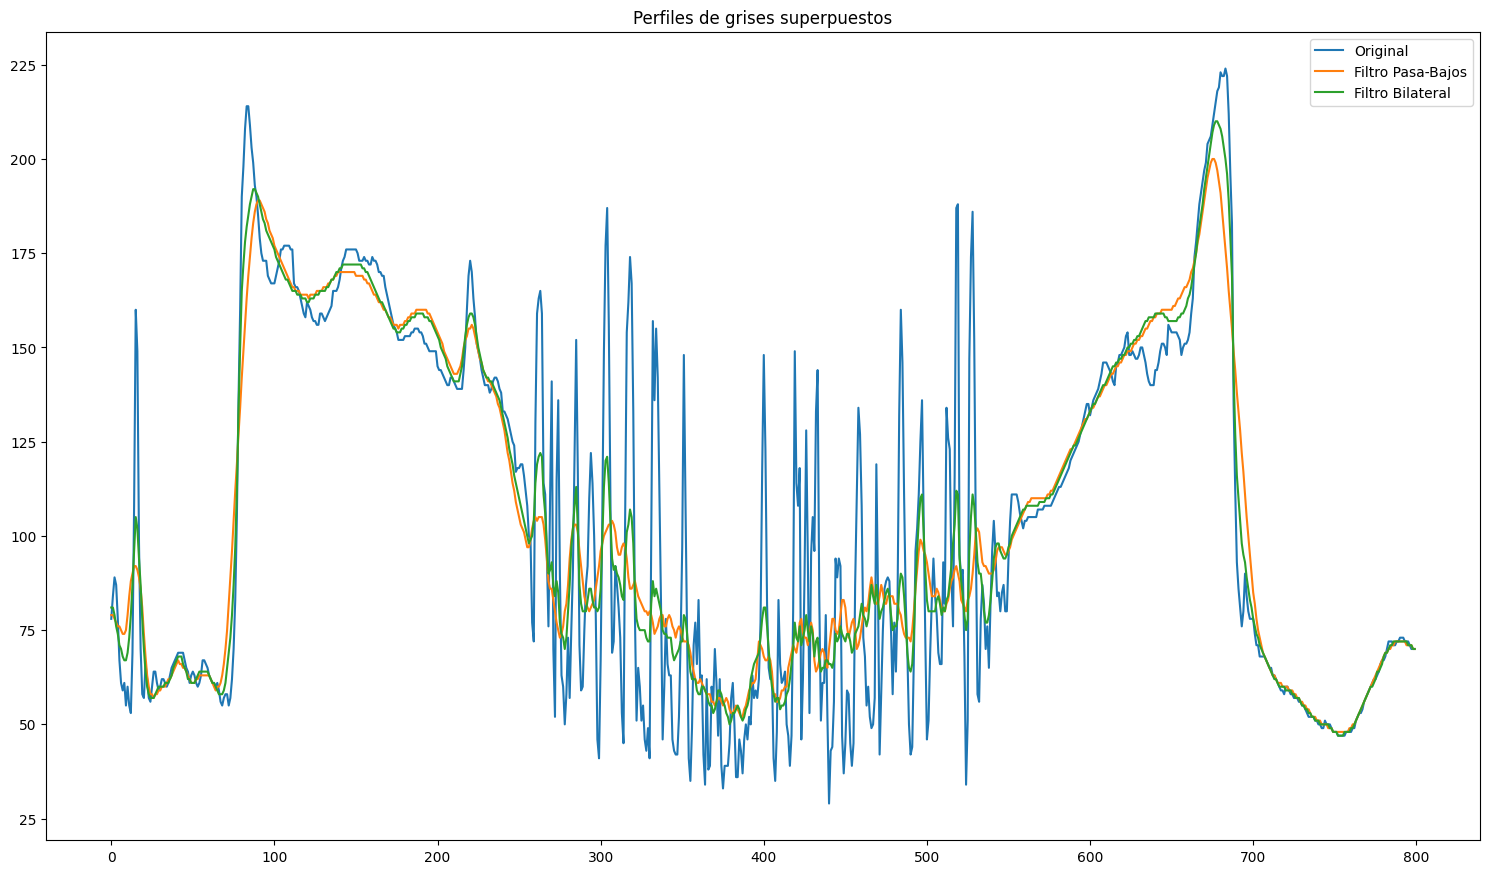

In [10]:
#Flores
flores= cv2.imread(path_imagenes[1],cv2.IMREAD_GRAYSCALE)
flores_procesada = process_image(path_imagenes[1],kernel_size=9,bilateral_param=100)
fix_line_flores = 250

perfil_flores = perfil_grises(flores,fix_line_flores,0)
perfil_flores_suav = perfil_grises(flores_procesada[0],fix_line_flores,0)
perfil_flores_bil = perfil_grises(flores_procesada[1],fix_line_flores,0)
perfiles_flores = [perfil_flores, perfil_flores_suav,perfil_flores_bil]

# plot_perfil_grises(perfiles_flores)
plot_perfil_grises_superpuestos(perfiles_flores)
# plot_perfil_sin_original([perfil_flores_suav,perfil_flores_bil])

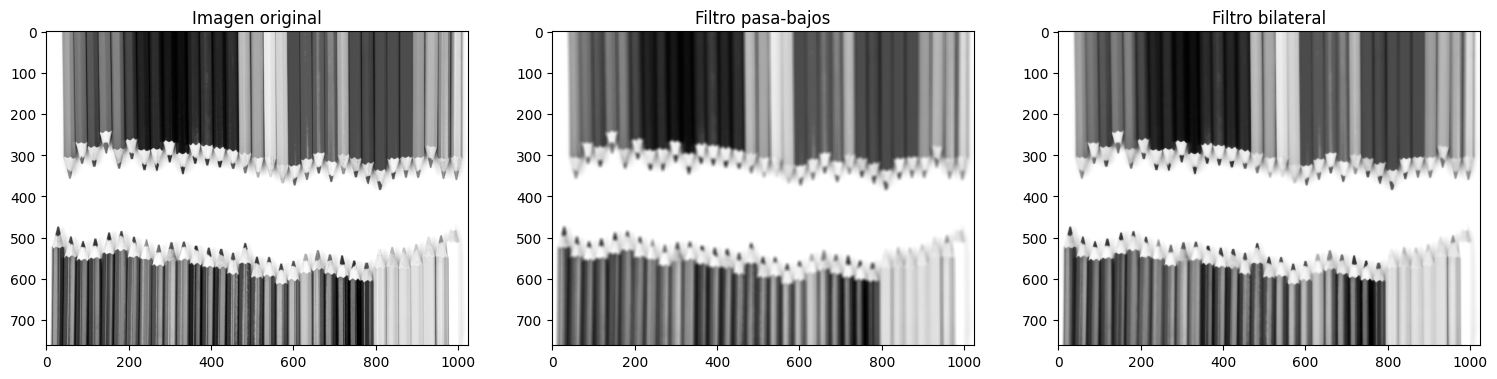

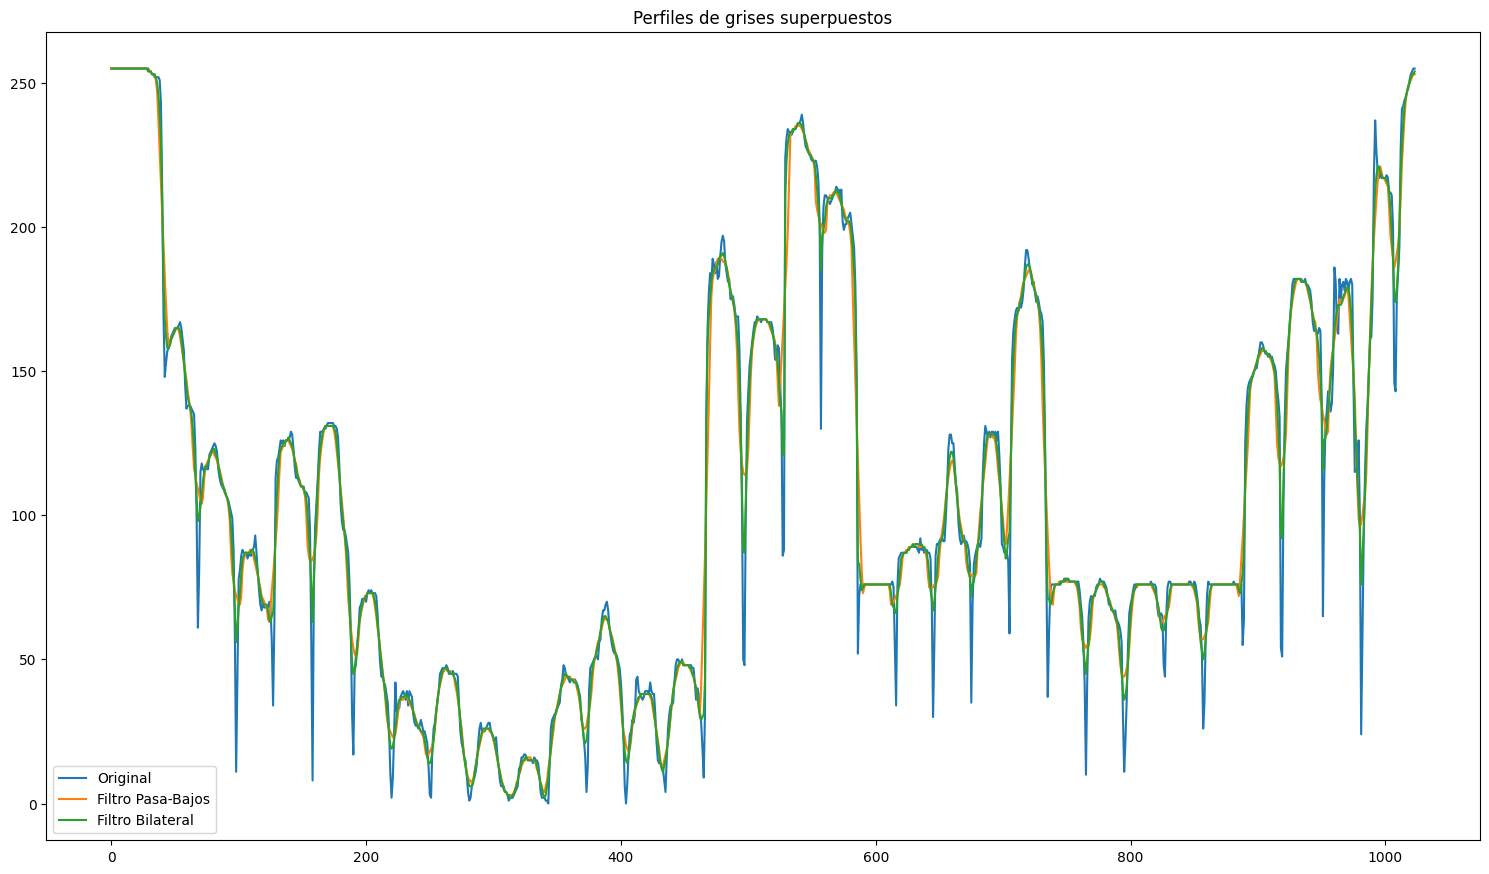

In [11]:
#Lapices
lapices= cv2.imread(path_imagenes[2],cv2.IMREAD_GRAYSCALE)
lapices_procesada = process_image(path_imagenes[2],kernel_size=9,bilateral_param=75)

fix_line_lapices = 100

perfil_lapices = perfil_grises(lapices,fix_line_lapices,0)
perfil_lapices_suav = perfil_grises(lapices_procesada[0],fix_line_lapices,0)
perfil_lapices_bil = perfil_grises(lapices_procesada[1],fix_line_lapices,0)
perfiles_lapices = [perfil_lapices, perfil_lapices_suav,perfil_lapices_bil]

plot_perfil_grises_superpuestos(perfiles_lapices)
# plot_perfil_grises(perfiles_lapices)

Al graficar los perfiles de grises puede observarse que los picos de intensidad (maximos y minimos) se atenúan luego de aplicar los filtros, y se atenúan más utilizando el filtro pasa-bajos que con el filtro bilateral.

# Guía 4 - Ejercicio 5.2
El gobierno de la provincia de Misiones lo ha contratado para realizar una aplicacion que sea capaz de detectar zonas deforestadas. Para desarrollar un primer prototipo le han suministrado una imagen satelital (*Deforestacion.png*) en la que un experto ya delimito el area donde debera existir monte nativo y sobre la cual usted debe trabajar. Se requiere que su aplicacion:
- Segmente y resalte en algun tono de rojo el area deforestada.
- Calcule el area total (hectareas) de la zona delimitada, el area de la zona que tiene monte y el area de la zona deforestada.
- (Opcional) Detecte automaticamente la delimitacion de la zona.

Ayuda:
- Explore todos los canales de los diferentes modelos de color para determinar cual (o que combinacion de ellos) le proporciona mas informacion.
- Como su objetivo es la segmentacion de las distintas zonas, piense que herramienta. (de las que ya conoce) le permitiria lograr zonas mas homogeneas.
- Utilice la referencia de la esquina inferior izquierda para computar los tamaños de las regiones.

Resolución:

Los pasos que seguiremos son:
1. Cargar la imagen, determinar la región de interés (ROI) y separarla en una variable.
2. Preprocesar la ROI aplicándole un filtro de suavizado para homogeneizar los valores de la imágen, haciendo que pueda distinguirse de una mejor manera las zonas deforestadas.
3. Transformar la ROI de un modelo RGB a uno HSL para poder analizar el perfil de intensidades (en este caso de Lightness, por ser un modelo HSL) en varios sectores y poder definir visualmente qué valores de L corresponden con una zona deforestada. Nosotros definimos el umbral en 83, los píxeles de la imagen con un valor de L menor al mismo corresponden a píxeles de una zona deforestada.
4. Recorrer los píxeles de la imagen contando aquellos que son píxeles deforestados y cambiándoles el Hue a un valor que corresponde a Rojo para poder distinguirlos mejor. 
5. Convertir la cantidad de píxeles contados a un valor en héctareas.

In [12]:
# Funciones utilizadas
def plot_perfil(imagen,i):
    fig,ax= plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.plot(imagen[i,:,2])
    plt.plot()

def comparar_hsv_hls(imagen_hsv,imagen_hls,i):
    fig,ax= plt.subplots(1,2)
    fig.set_size_inches(18.5, 10.5)
    ax[0].plot(imagen_hsv[i,:,2])
    ax[1].plot(imagen_hls[i,:,1])

    ax[0].set_title("Perfil de grises de una zona de al imagen con modelo HSV")
    ax[1].set_title("Perfil de grises de una zona de al imagen con modelo HSL")
    plt.plot()

def detectar_zona(imagen):
    lookUpTable = np.zeros((1,256), np.uint8)
    for i in range(200,256):
        lookUpTable[0,i] = i
    
    imagen_mask = cv2.LUT(imagen,lookUpTable)
    print(imagen_mask.shape)
    plt.figure()
    plt.imshow(imagen_mask[273:706,151:730])
    plt.show()

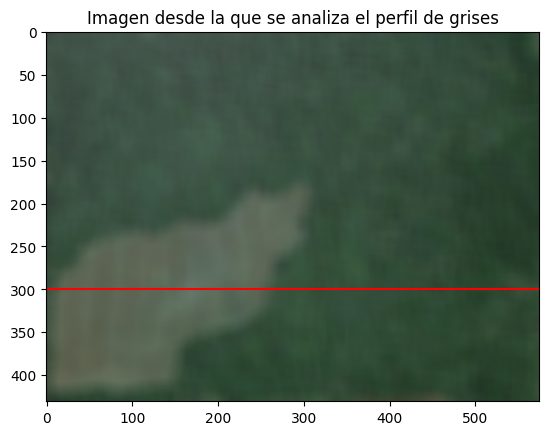

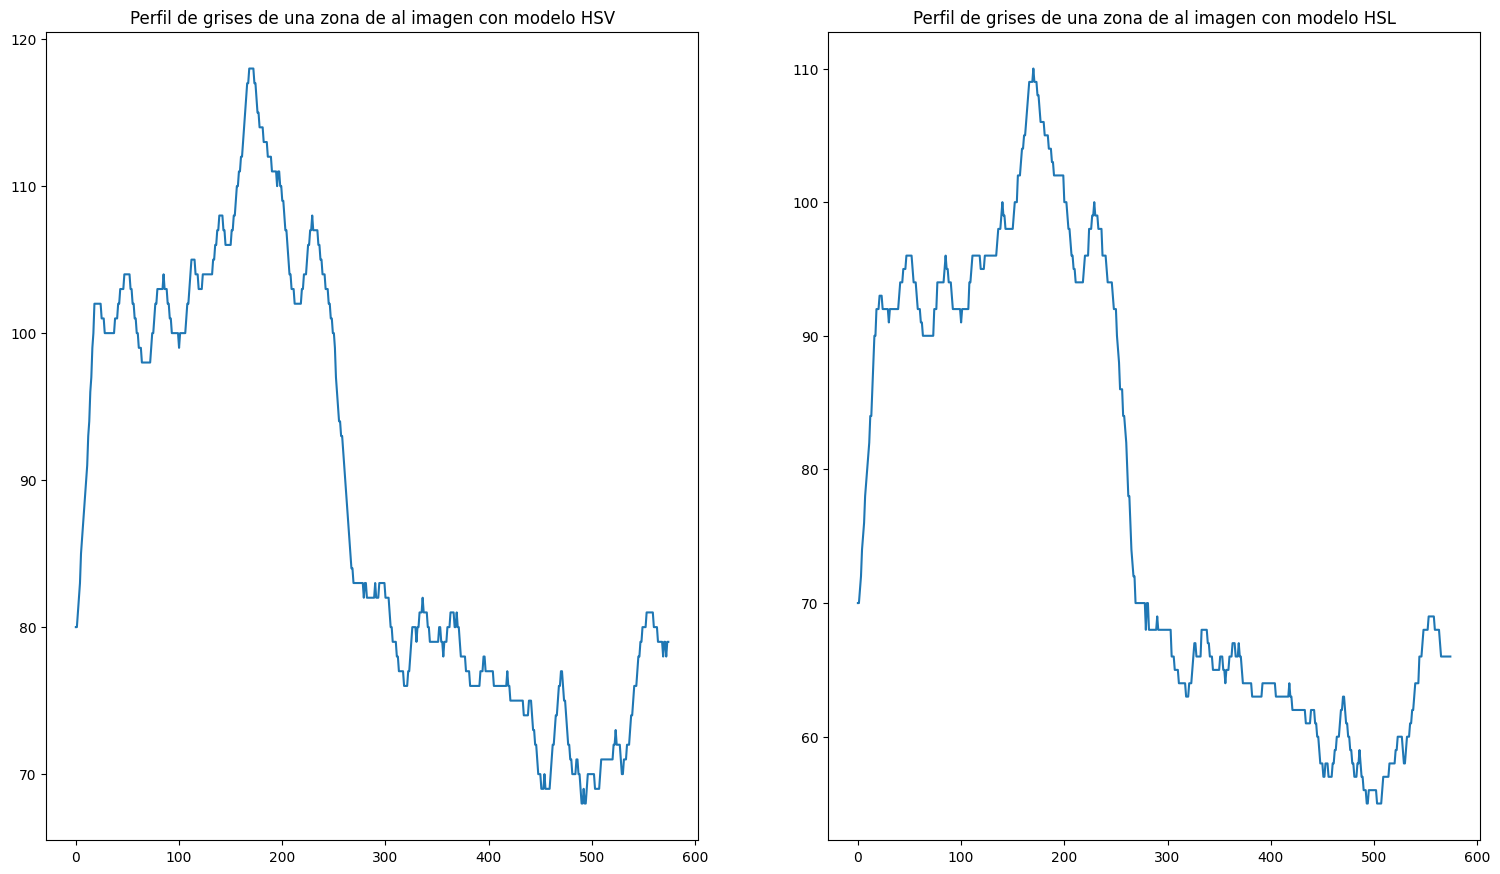

In [13]:
deforestacion_path = "images/Deforestacion.png"
rango = [[275,706],[155,730]]

deforestacion = cv2.imread(deforestacion_path)
deforestacion = cv2.cvtColor(deforestacion,cv2.COLOR_BGR2RGB)
def_roi = deforestacion[rango[0][0]:rango[0][1],rango[1][0]:rango[1][1]]
deforestacion_hsv = cv2.cvtColor(def_roi,cv2.COLOR_RGB2HSV)
deforestacion_hls = cv2.cvtColor(def_roi,cv2.COLOR_RGB2HLS)

kernel_size=20
kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)
kernel /= (kernel_size**2)

deforestacion_blur = cv2.filter2D(def_roi,-1,kernel,borderType=cv2.BORDER_REPLICATE)
deforestacion_blur_hsv = cv2.cvtColor(deforestacion_blur,cv2.COLOR_RGB2HSV)
deforestacion_blur_hls = cv2.cvtColor(deforestacion_blur,cv2.COLOR_RGB2HLS)

fix_line = 300
plt.figure()
plt.imshow(deforestacion_blur)
plt.title("Imagen desde la que se analiza el perfil de grises")
plt.plot([0,deforestacion_blur.shape[1]-1],[fix_line,fix_line],"r")
comparar_hsv_hls(deforestacion_blur_hsv,deforestacion_blur_hls,fix_line)

Elegimos utilizar el modelo HSL porque nos pareció que permite separar de mejor manera los valores que corresponden a zona deforestada que comparando con utilizar el modelo HSV.

Utilizando la escala que se encuentra en la zona inferior izquierda de la imagen puede encontrarse la relación entre distancia en metros y píxeles de la imagen. En este caso 100 píxeles equivalen a 200 metros. 
Si tomaramos entonces un cuadrado de 200 metros se obtendría un area de 40000 $m^2$, y esto a su vez es equivalente a un cuadrado de $100 \times  100$ píxeles, donde hay 10000 píxeles en total. Por esta razón puede decirse que 1 pixel de la imágen equivale a 4 $m^2$, y con esta información puede calcularse el área deforestada calculando la cantidad de píxeles que se encuentran con una intensidad que equivale a una zona deforestada.

Para pasar de metros cuadrados a hectáreas es necesario multiplicar el valor en $m^2$ por $0.0001$.

cantidad de hectareas sanas: 82.694800 ha
cantidad de hectareas deforestadas: 16.435200 ha


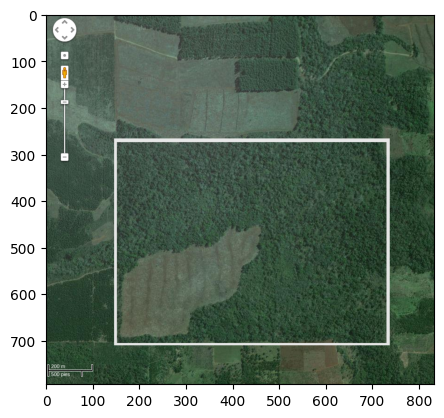

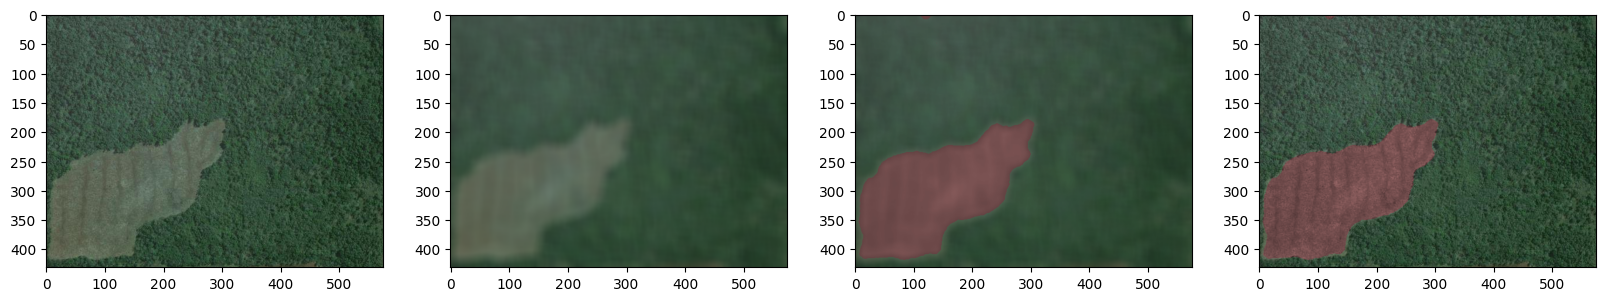

In [14]:
pixeles_deforestados = 0
deforestacion_blur_rojo = deforestacion_blur_hls.copy()
deforestacion_rojo = deforestacion_hls.copy()
for y in range(deforestacion_blur_hls.shape[0]):
    for x in range(deforestacion_blur_hls.shape[1]):
        if deforestacion_blur_hls[y,x,1] > 83:
            pixeles_deforestados +=1
            deforestacion_rojo[y,x,0] = 0
            deforestacion_rojo[y,x,2] = 50

            deforestacion_blur_rojo[y,x,0] = 0
            deforestacion_blur_rojo[y,x,2] = 50


pixeles_sanos = deforestacion_blur_rojo.shape[0]*deforestacion_blur_rojo.shape[1] - pixeles_deforestados
hectareas_sanas = pixeles_sanos * 4 * 0.0001
hectareas_deforestadas = pixeles_deforestados * 4 * 0.0001
print("cantidad de hectareas sanas: %f ha"%(hectareas_sanas))
print("cantidad de hectareas deforestadas: %f ha"%(hectareas_deforestadas))

deforestacion_rojo = cv2.cvtColor(deforestacion_rojo,cv2.COLOR_HLS2RGB)
deforestacion_blur_rojo = cv2.cvtColor(deforestacion_blur_rojo,cv2.COLOR_HLS2RGB)

plt.figure()
plt.imshow(deforestacion)
plt.plot()

plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.subplot(1,4,1)
plt.imshow(def_roi)

plt.subplot(1,4,2)
plt.imshow(deforestacion_blur)

plt.subplot(1,4,3)
plt.imshow(deforestacion_blur_rojo)

plt.subplot(1,4,4)
plt.imshow(deforestacion_rojo)
plt.show()
